In [2]:
from pathlib import Path
import importlib
import re

import dill
import numpy as np
import pandas as pd
import scipy as sci
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec

import gm
from config import cfg, ROOT
from src.data import get_rgi
from src.flowline import get_flowline_geom

%matplotlib inline

In [3]:
glacier = 'Hintereisferner'
rgiid = list({k: v for k, v in cfg['glaciers'].items() if v['name'] == glacier}.keys())[0]
rgi = get_rgi(rgiid, from_sqllite=True)
trgi = int(rgi.iloc[0]['BgnDate'][0:4])  # time rgi


C:\sandbox\glacier-attribution\src\flowline.py:52: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  fl, inv, dsl = pickle.load(openfile)
C:\sandbox\glacier-attribution\src\flowline.py:56: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mfl = pickle.load(openfile)
C:\sandbox\glacier-attribution\src\flowline.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\sandbox\glacier-attribution\src\flowline.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


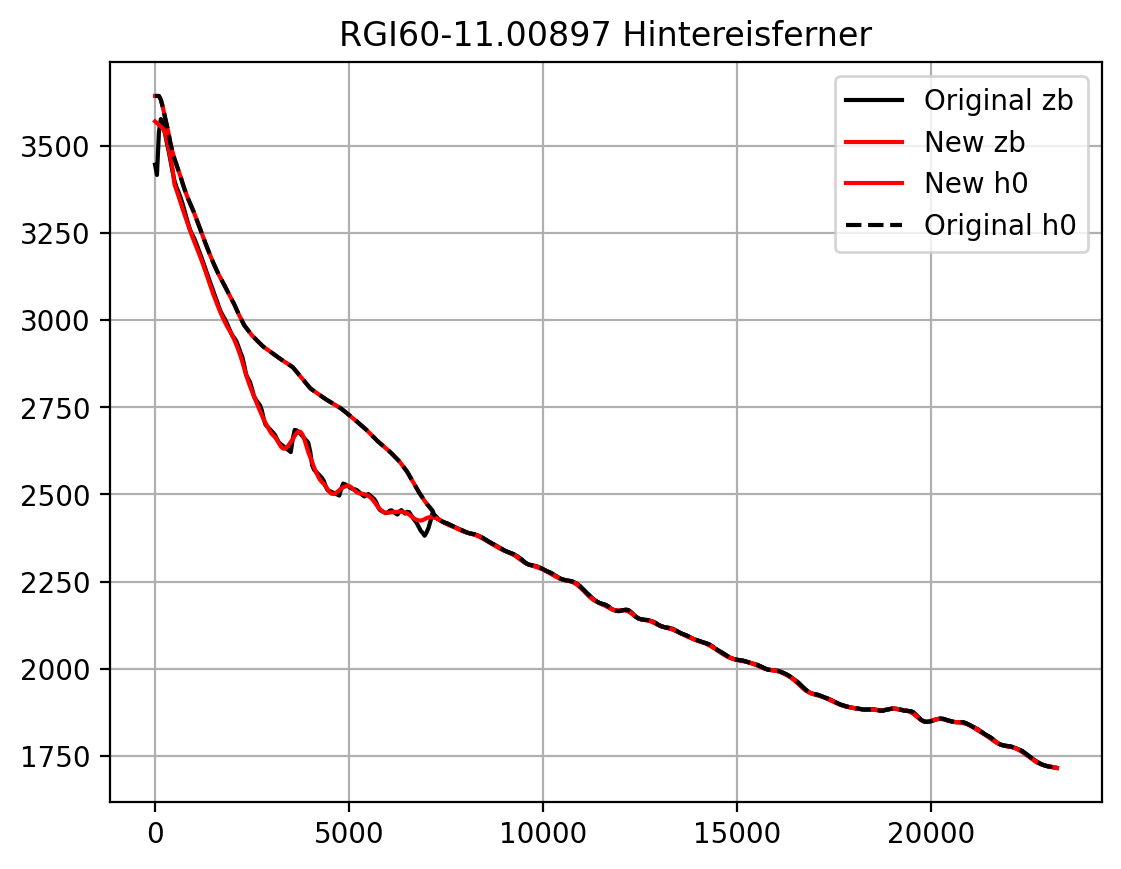

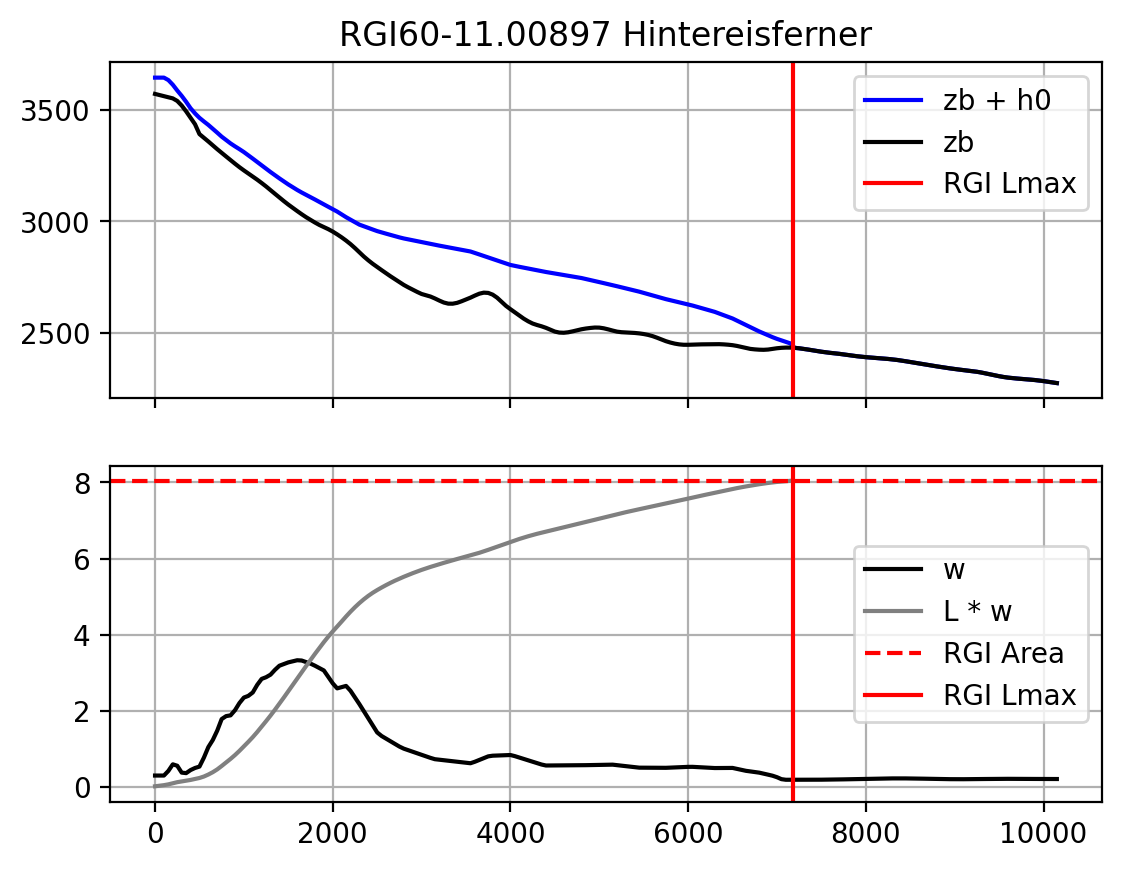

In [4]:
geom = get_flowline_geom(rgiid)

# Calibrate without noise

In [5]:
import config

importlib.reload(config)
from config import cfg

params = cfg['glaciers'][rgiid]['flowline_params']

# use random precip instead of LMR precip
df = pd.read_csv(Path(ROOT, r"features\ClimateRandom.csv"))
t0 = 850
t1 = 5000
ref0 = 850
ref1 = 900
t = np.arange(t0, t1, 1)
T = df['T'].iloc[t0:t1]
T.index = t
P = df['P'].iloc[t0:t1]
P.index = t
Pref = 0
Tref = T.loc[ref0:ref1].mean()
T = T - Tref
P = P - Pref
temp = None

fp = Path(ROOT, params['ss.synthetic.profile'])
with open(fp, 'rb') as f:
    last_run = dill.load(f)
    h_init = last_run.h[-1, :]
    x_init = last_run.x

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp, sigT=0, sigP=0, P0=params['P0'],
                      delt=0.0125 / (params['dt_max']), delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.T0.synth'],
                      T=T, P=P, rt_plot=False, dt_plot=20)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
#model.nrun = nrun  # ensemble number
model.ref_period = (ref0, ref1)

100%|#######################################################| 4149.0/4149.0 [02:55<00:00, 23.70yrs/s


T0 = 21.62


<Figure size 1800x1000 with 0 Axes>

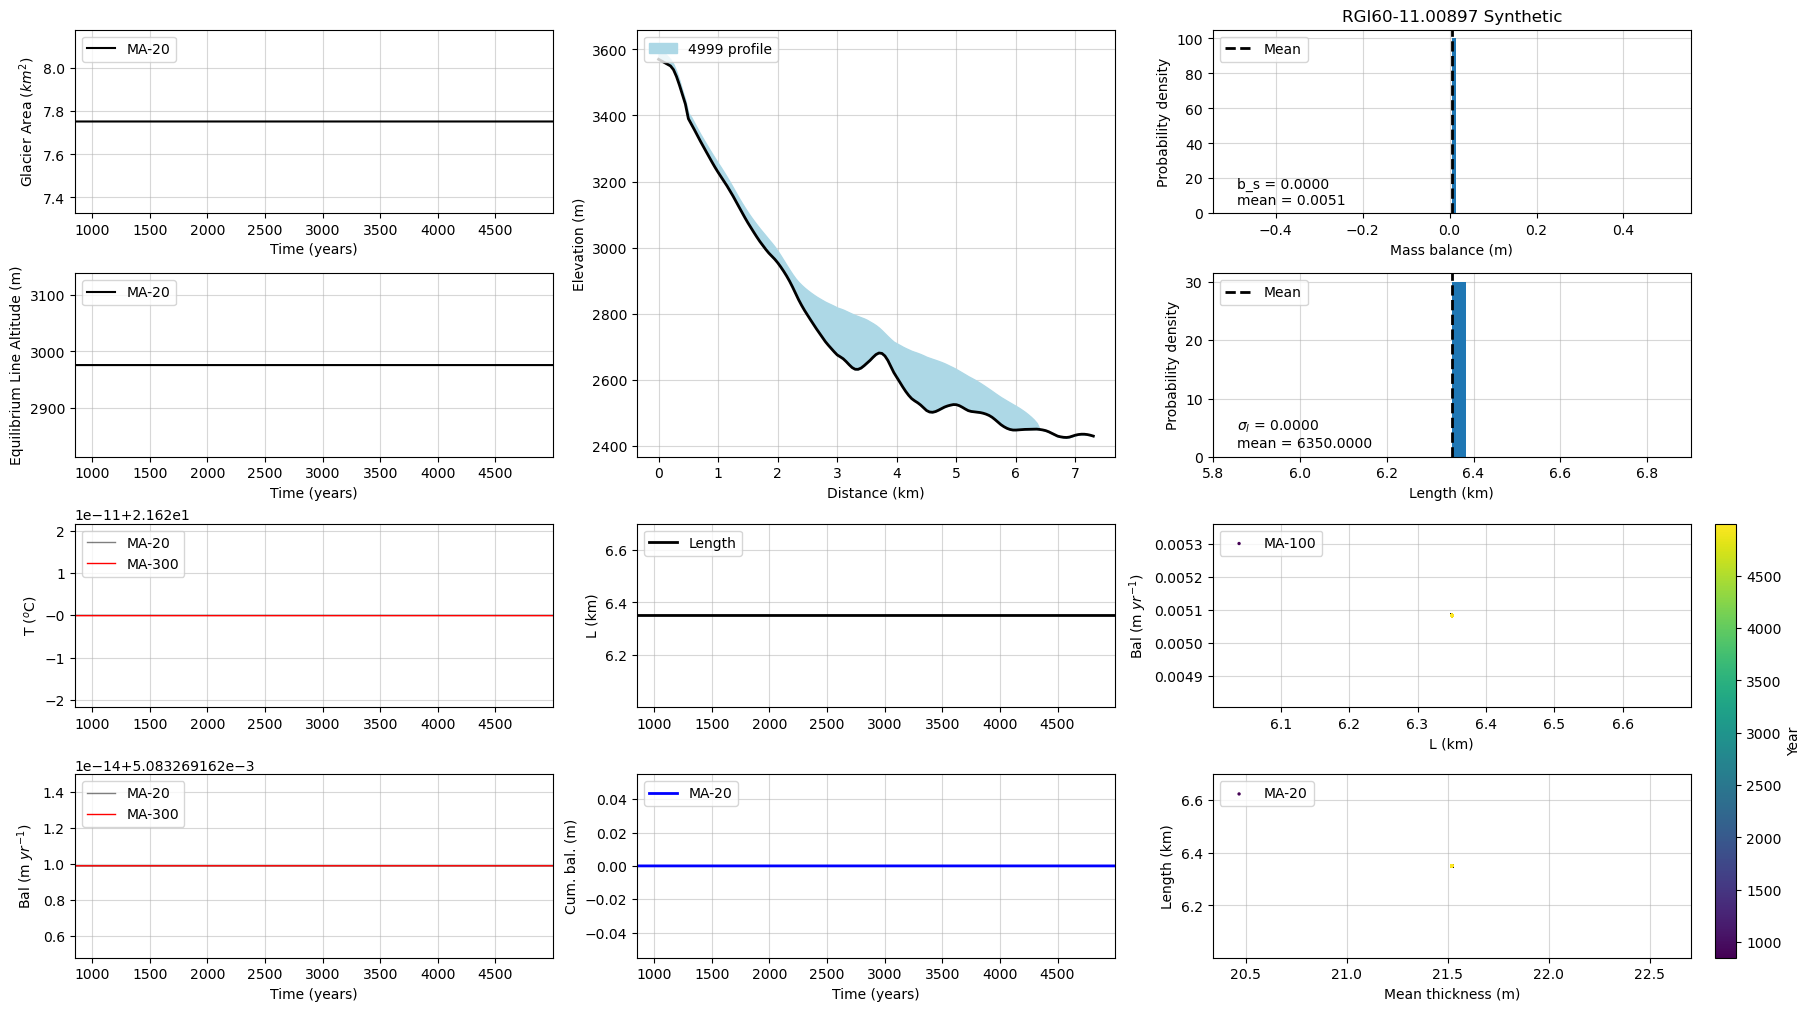

<Figure size 640x480 with 0 Axes>

In [6]:
print(f"T0 = {params['ss.T0.synth']}")

fig, ax = model.plot()
ax[0, 2].set_title(f'{rgiid} Synthetic')
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.ss.synthetic.png')
fig.savefig(fig_output_name)

fig

In [7]:
file_output_name = Path(ROOT, f'flowline2d_{rgiid}.ss.synthetic.pickle')
model.to_pickle(file_output_name)

# Check flowline calibration with temperature ramp but without noise
Match 1850 length with known length

100%|#######################################################| 1149.0/1149.0 [00:24<00:00, 47.71yrs/s

T0 = 21.62


<Figure size 1800x1000 with 0 Axes>

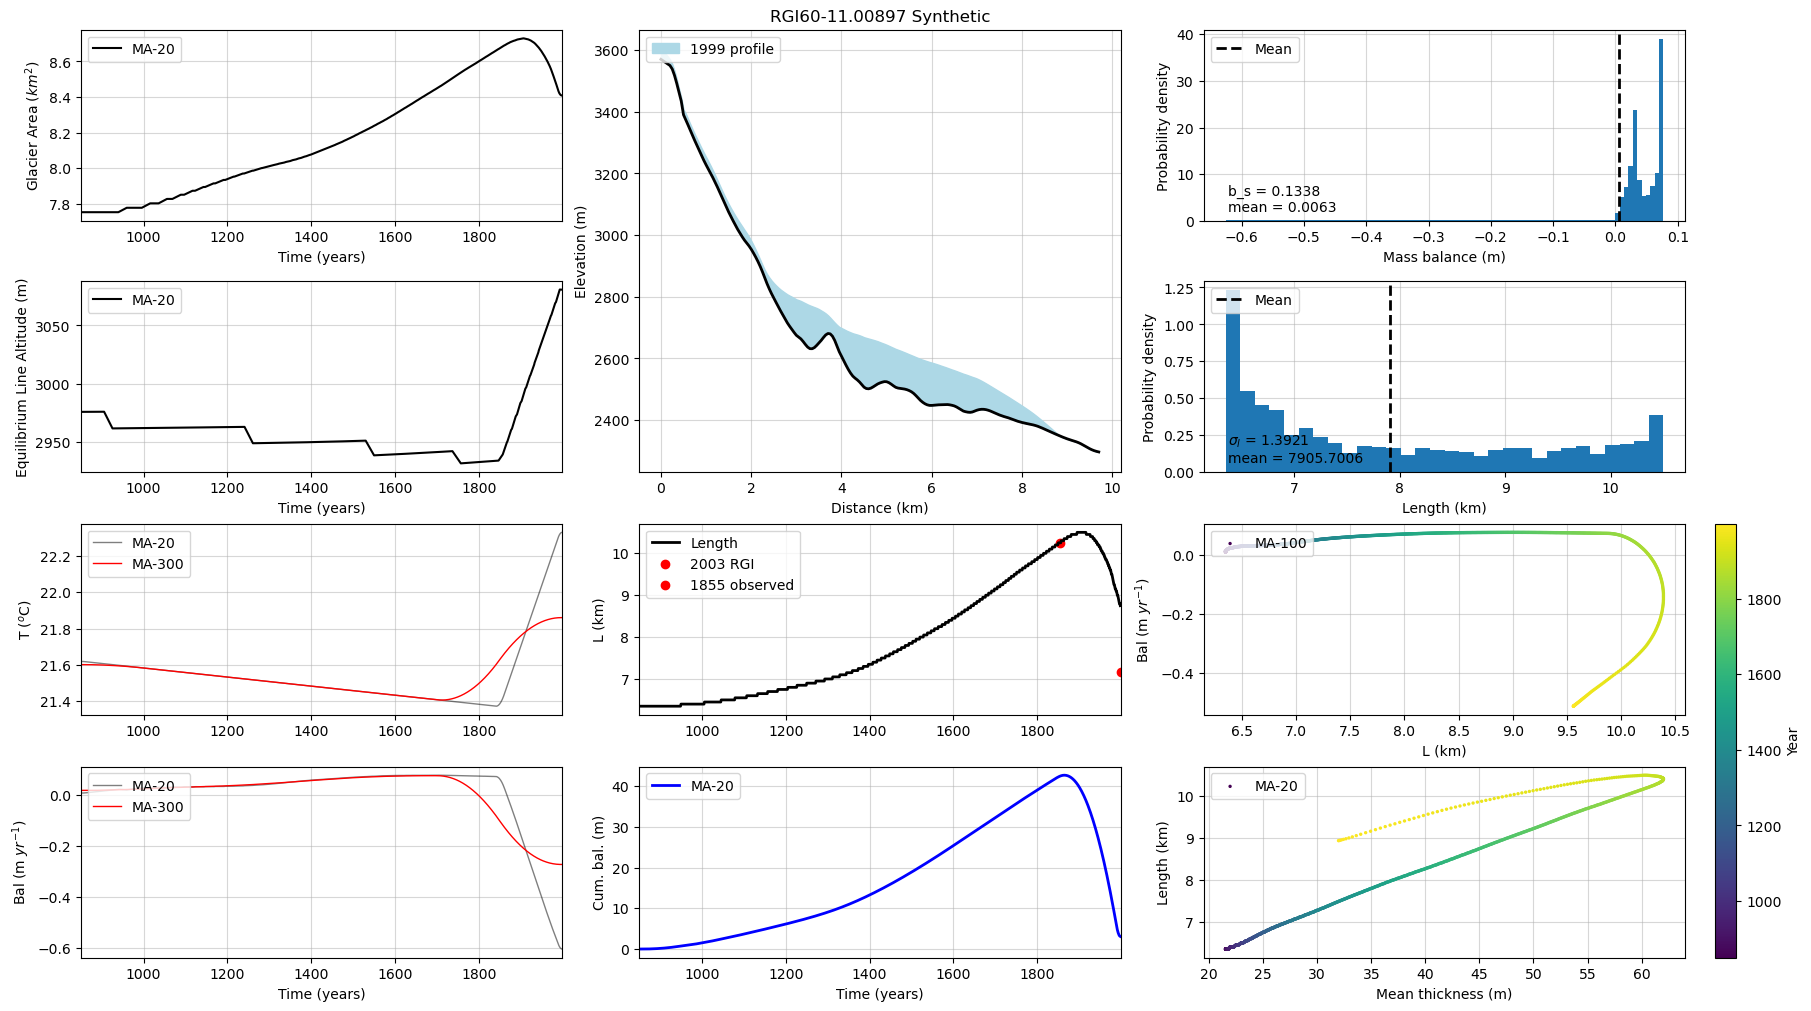

<Figure size 640x480 with 0 Axes>

In [8]:
import config

importlib.reload(config)
from config import cfg

params = cfg['glaciers'][rgiid]['flowline_params']

# use random precip instead of LMR precip
df = pd.read_csv(Path(ROOT, r"features\ClimateRandom.csv"))
t0 = 850
t1 = 2000
ref0 = 850
ref1 = 900
t = np.arange(850, 2000, 1)
T = df['T'].iloc[t0:t1]
T.index = t
P = df['P'].iloc[t0:t1]
P.index = t
Pref = 0
Tref = T.loc[ref0:ref1].mean()
T = T - Tref
P = P - Pref
temp = pd.Series(np.concatenate([np.linspace(0, -0.25, 1000), np.linspace(-.25, 0.75, 150)]), index=t)

fp = Path(ROOT, params['ss.synthetic.profile'])
with open(fp, 'rb') as f:
    last_run = dill.load(f)
    h_init = last_run.h[-1, :]
    x_init = last_run.x

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp, sigT=0, sigP=0, P0=params['P0'],
                      delt=0.0125 / (params['dt_max']), delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.T0.synth'],
                      T=T, P=P, rt_plot=False, dt_plot=20)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
#model.nrun = nrun  # ensemble number
model.ref_period = (ref0, ref1)

print(f"T0 = {params['ss.T0.synth']}")

fig, ax = model.plot()
ax[0, 1].set_title(f'{rgiid} Synthetic')
ax[2, 1].scatter(min(1999, trgi), rgi.Lmax / 1000, c='red', label=f'{trgi} RGI')
ax[2, 1].scatter(params['L0']['year'], params['L0']['value'] / 1000, c='red', label=f"{params['L0']['year']} observed")
ax[2, 1].legend()
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.synthetic.png')
fig.savefig(fig_output_name)

file_output_name = Path(ROOT,
                        f'flowline2d_{rgiid}.synthetic.pickle')
model.to_pickle(file_output_name)

fig

# Create Noise
We want to repeat the process with noise, with the end goal of running a 20 member ensemble around a central estimate. Our synthetic temperature ramp is basis for this noise, but to get our central estimate we take 20 samples of random noise.

In [9]:
rng = np.random.default_rng(12345)
nruns = 20
t0 = 850
t1 = 2000
t = np.arange(t0, t1, 1)
Tnoise = []
Pnoise = []

for n in range(nruns):
    T = pd.Series(rng.standard_normal(len(t)), index=t)
    P = pd.Series(rng.standard_normal(len(t)), index=t)
    Tnoise.append(T)
    Pnoise.append(P)


In [10]:
Tmean = pd.concat(Tnoise).mean()
Pmean = pd.concat(Pnoise).mean()
print(Tmean)
print(Pmean)

0.0068561696943322484
-0.0017773881223020122




# Calibrate for white noise
To run the flowline with noise but without a divergence at initialization, we calibrate with noise to generate an ice profile. The resulting ice profile is used for the flowline (with noise) and adjusted until the flowline passes through the 1850 location. Cycle between this step and the next step until the glacier is both in equilibrium at T0 and passes through the 1850 position.

If the length needs to be adjusted, we save the ice profile & use it for the next iteration, honing in on the correct T0 while also adjusting the ice profile. Instead of using the final position from the previous simulation, the median ice profile over the entire previous simulation is used as the starting point for the next one. Because the glacier is noisy in this case, the median profile will stay consistent for a calibrated glacier with a sufficient simulation length.

100%|######################################################| 1649.0/1649.0 [00:10<00:00, 154.96yrs/s

T0 = 21.58


<Figure size 1800x1000 with 0 Axes>

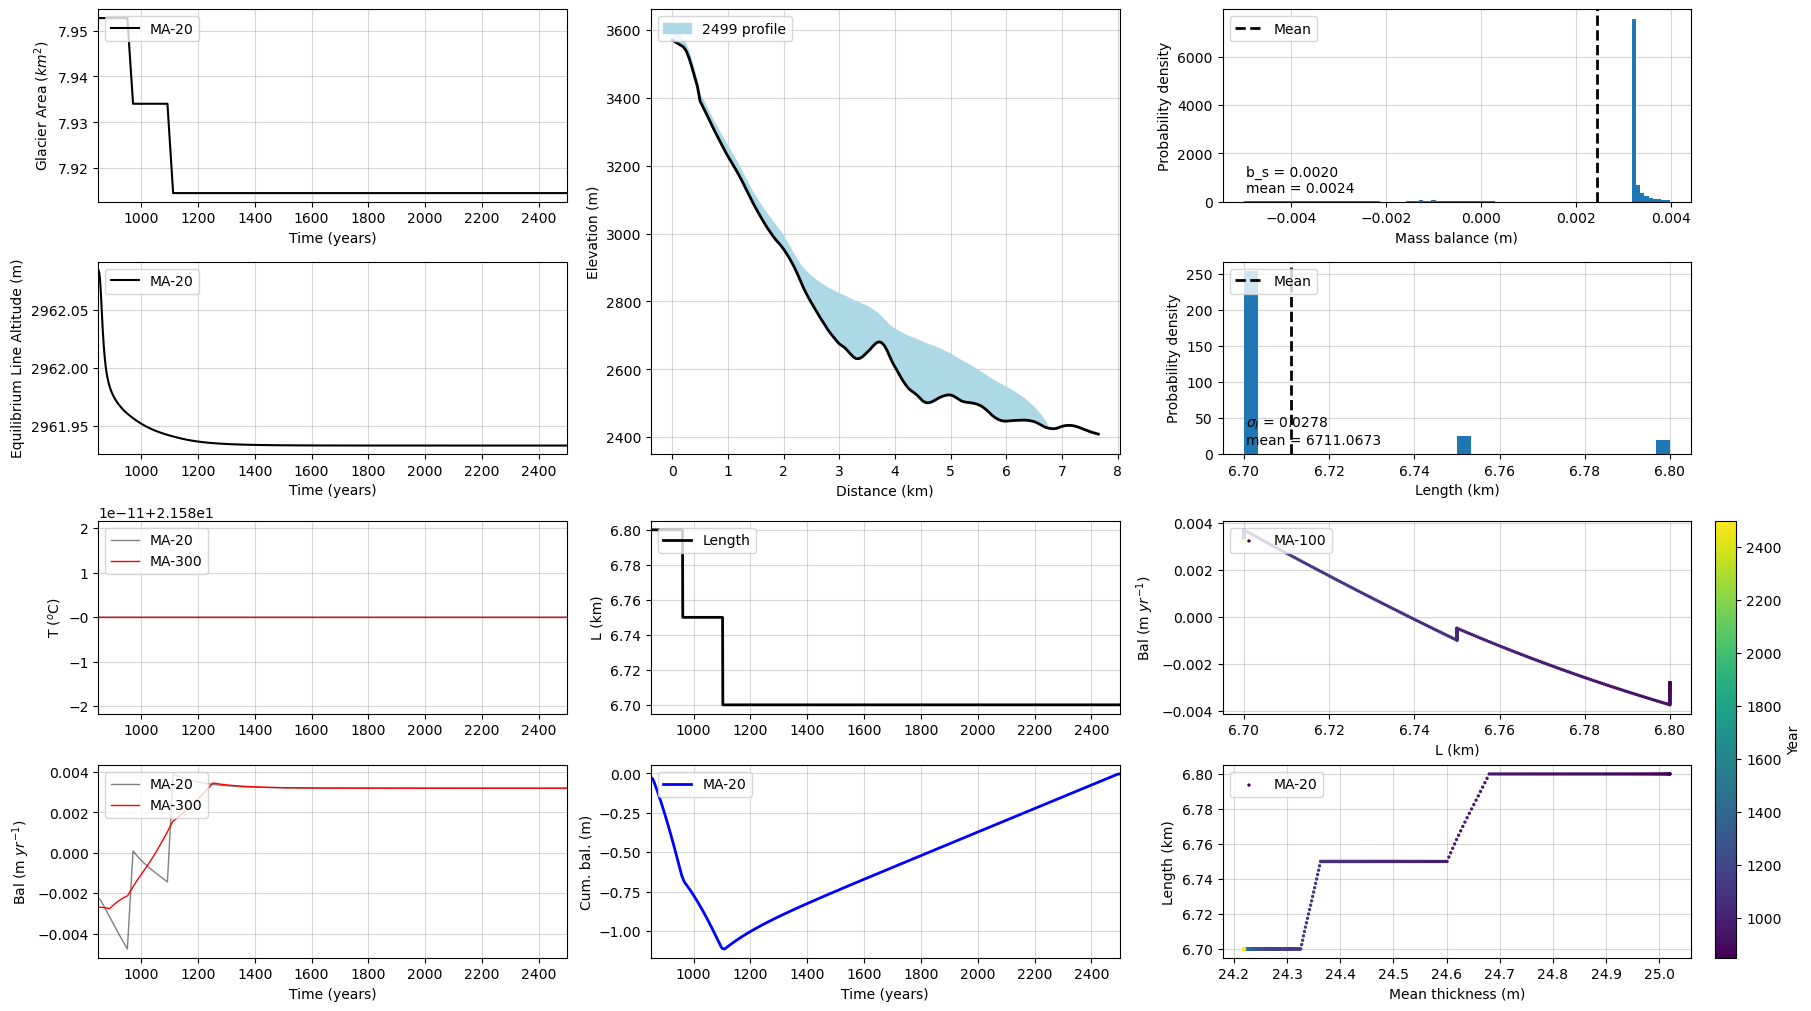

<Figure size 640x480 with 0 Axes>

In [149]:

import config

importlib.reload(config)
from config import cfg

params = cfg['glaciers'][rgiid]['flowline_params']

df = pd.read_csv(Path(ROOT, r"features\ClimateRandom.csv"))
t0 = 850
t1 = 2500
ref0 = 850
ref1 = 900
t = np.arange(t0, t1, 1)
T = df['T'].iloc[t0:t1]
T.index = t
P = df['P'].iloc[t0:t1]
P.index = t
Pref = 0
Tref = T.loc[ref0:ref1].mean()
T = T - Tref
P = P - Pref
temp = None

try:
    fp = Path(ROOT, params['ss.noise.synthetic.profile'])
    with open(fp, 'rb') as f:
        last_run = dill.load(f)
        h_init = last_run.h[-1, :]
        x_init = last_run.x
except:
    fp = Path(ROOT, params['ss.synthetic.profile'])
    with open(fp, 'rb') as f:
        last_run = dill.load(f)
        h_init = last_run.h[-1, :]
        x_init = last_run.x

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp, sigT=0, sigP=0, P0=params['P0'],
                      delt=0.0125 / (params['dt_max']), delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.noise.T0.synth'],
                      T=T, P=P, rt_plot=False, dt_plot=20)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
#model.nrun = nrun  # ensemble number
model.ref_period = (ref0, ref1)

print(f"T0 = {params['ss.noise.T0.synth']}")

fig, ax = model.plot()
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.ss.noise.synthetic.png')
fig.savefig(fig_output_name)
fig


In [150]:
file_output_name = Path(ROOT, f'flowline2d_{rgiid}.ss.noise.synthetic.pickle')
model.to_pickle(file_output_name)

# Do the same thing
But now with the temperature ramp to see where it ends up

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 139.12yrs/s

T0 = 21.58


<Figure size 1800x1000 with 0 Axes>

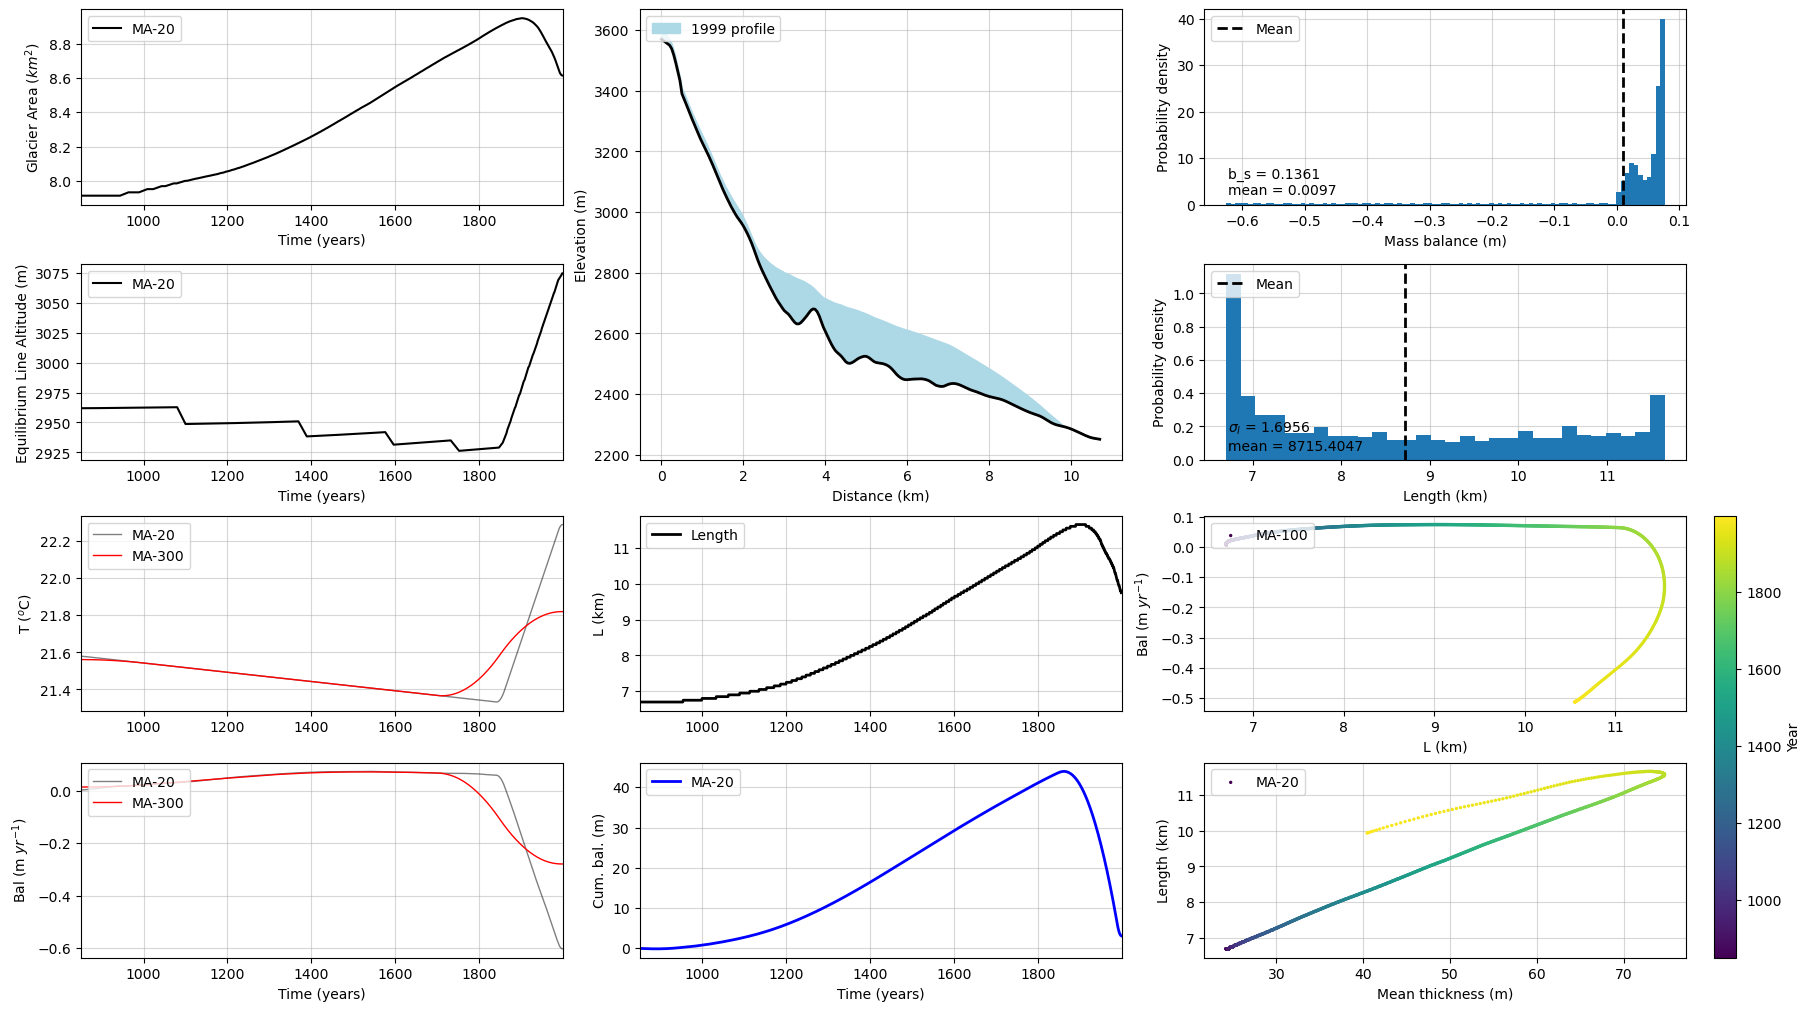

<Figure size 640x480 with 0 Axes>

In [151]:

import config

importlib.reload(config)
from config import cfg

params = cfg['glaciers'][rgiid]['flowline_params']

df = pd.read_csv(Path(ROOT, r"features\ClimateRandom.csv"))
t0 = 850
t1 = 2000
ref0 = 850
ref1 = 900
t = np.arange(t0, t1, 1)
T = df['T'].iloc[t0:t1]
T.index = t
P = df['P'].iloc[t0:t1]
P.index = t
Pref = 0
Tref = T.loc[ref0:ref1].mean()
T = T - Tref
P = P - Pref
temp = pd.Series(np.concatenate([
    np.linspace(0, -0.25, 1000),
    np.linspace(-.25, 0.75, 150)
]), index=t)

try:
    fp = Path(ROOT, params['ss.noise.synthetic.profile'])
    with open(fp, 'rb') as f:
        last_run = dill.load(f)
        h_init = last_run.h[-1, :]
        x_init = last_run.x
except:
    fp = Path(ROOT, params['ss.synthetic.profile'])
    with open(fp, 'rb') as f:
        last_run = dill.load(f)
        h_init = last_run.h[-1, :]
        x_init = last_run.x

model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                      h_init=h_init, xmx=geom.x.max(),
                      temp=temp, sigT=0, sigP=0, P0=params['P0'],
                      delt=0.0125 / (params['dt_max']), delx=50,
                      ts=int(T.index[0]), tf=int(T.index[-1]), T0=params['ss.noise.T0.synth'],
                      T=T, P=P, rt_plot=False, dt_plot=20)
model.Tref = Tref  # additional variable to save for later analysis
model.Pref = Pref
#model.nrun = nrun  # ensemble number
model.ref_period = (ref0, ref1)

print(f"T0 = {params['ss.noise.T0.synth']}")

fig, ax = model.plot()
fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.ss.noise.synthetic.png')
fig.savefig(fig_output_name)
fig


# Run the ensemble
Once we start to get realistic 1850 lengths, increase the number of ensemble members

In [152]:
Tref = 0
Pref = 0

T0 = params['ss.noise.T0.synth']
t = np.arange(850, 2000, 1)
temp = pd.Series(np.concatenate([
    np.linspace(0, -0.25, 1000),
    np.linspace(-.25, 0.75, 150)
]), index=t)
nruns = 20
print(f"T0 = {T0}")

fp = Path(ROOT, params['ss.noise.synthetic.profile'])
with open(fp, 'rb') as f:
    last_run = dill.load(f)
    h_init = last_run.h[-1, :]
    x_init = last_run.x

for nrun in range(nruns):
    T = Tnoise[nrun] - Tref
    P = Pnoise[nrun] - Pref

    model = gm.flowline2d(x_gr=geom.x, zb_gr=geom.zb, x_geom=geom.x, w_geom=geom.w, x_init=x_init,
                          h_init=h_init, xmx=geom.x.max(),
                          temp=temp, sigT=params['sigT'], sigP=params['sigP'], P0=params['P0'],
                          delt=0.0125 / (params['dt_max']), delx=50, t_stab=None,
                          ts=int(T.index[0]), tf=int(T.index[-1]), T0=T0,
                          T=T, P=P,)
    model.Tref = Tref  # additional variable to save for later analysis
    model.Pref = Pref
    model.nrun = nrun  # ensemble number
    model.ref_period = (ref0, ref1)


    fig, ax = model.plot()
    ax[0,1].set_title(f'{rgiid} Synthetic ensemble #{nrun}')
    fig_output_name = Path(ROOT, f'flowline2d_{rgiid}.synthetic.{nrun}.png')
    fig.savefig(fig_output_name)
    file_output_name = Path(ROOT, f'flowline2d_{rgiid}.synthetic.{nrun}.pickle')
    model.to_pickle(file_output_name)

T0 = 21.58


100%|######################################################| 1149.0/1149.0 [00:08<00:00, 142.15yrs/s


<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:09<00:00, 126.86yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 138.66yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 135.02yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 142.61yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 134.07yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 137.14yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:07<00:00, 146.09yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 138.86yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:07<00:00, 144.37yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 133.29yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:09<00:00, 123.88yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:09<00:00, 115.32yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 134.05yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:09<00:00, 115.09yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:07<00:00, 148.45yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 129.33yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:07<00:00, 147.86yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:07<00:00, 154.20yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

100%|######################################################| 1149.0/1149.0 [00:08<00:00, 135.03yrs/s


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Visualize the ensemble

Text(0.5, 0.98, 'RGI60-11.00897 (Hintereisferner) Tref=850 - 900')

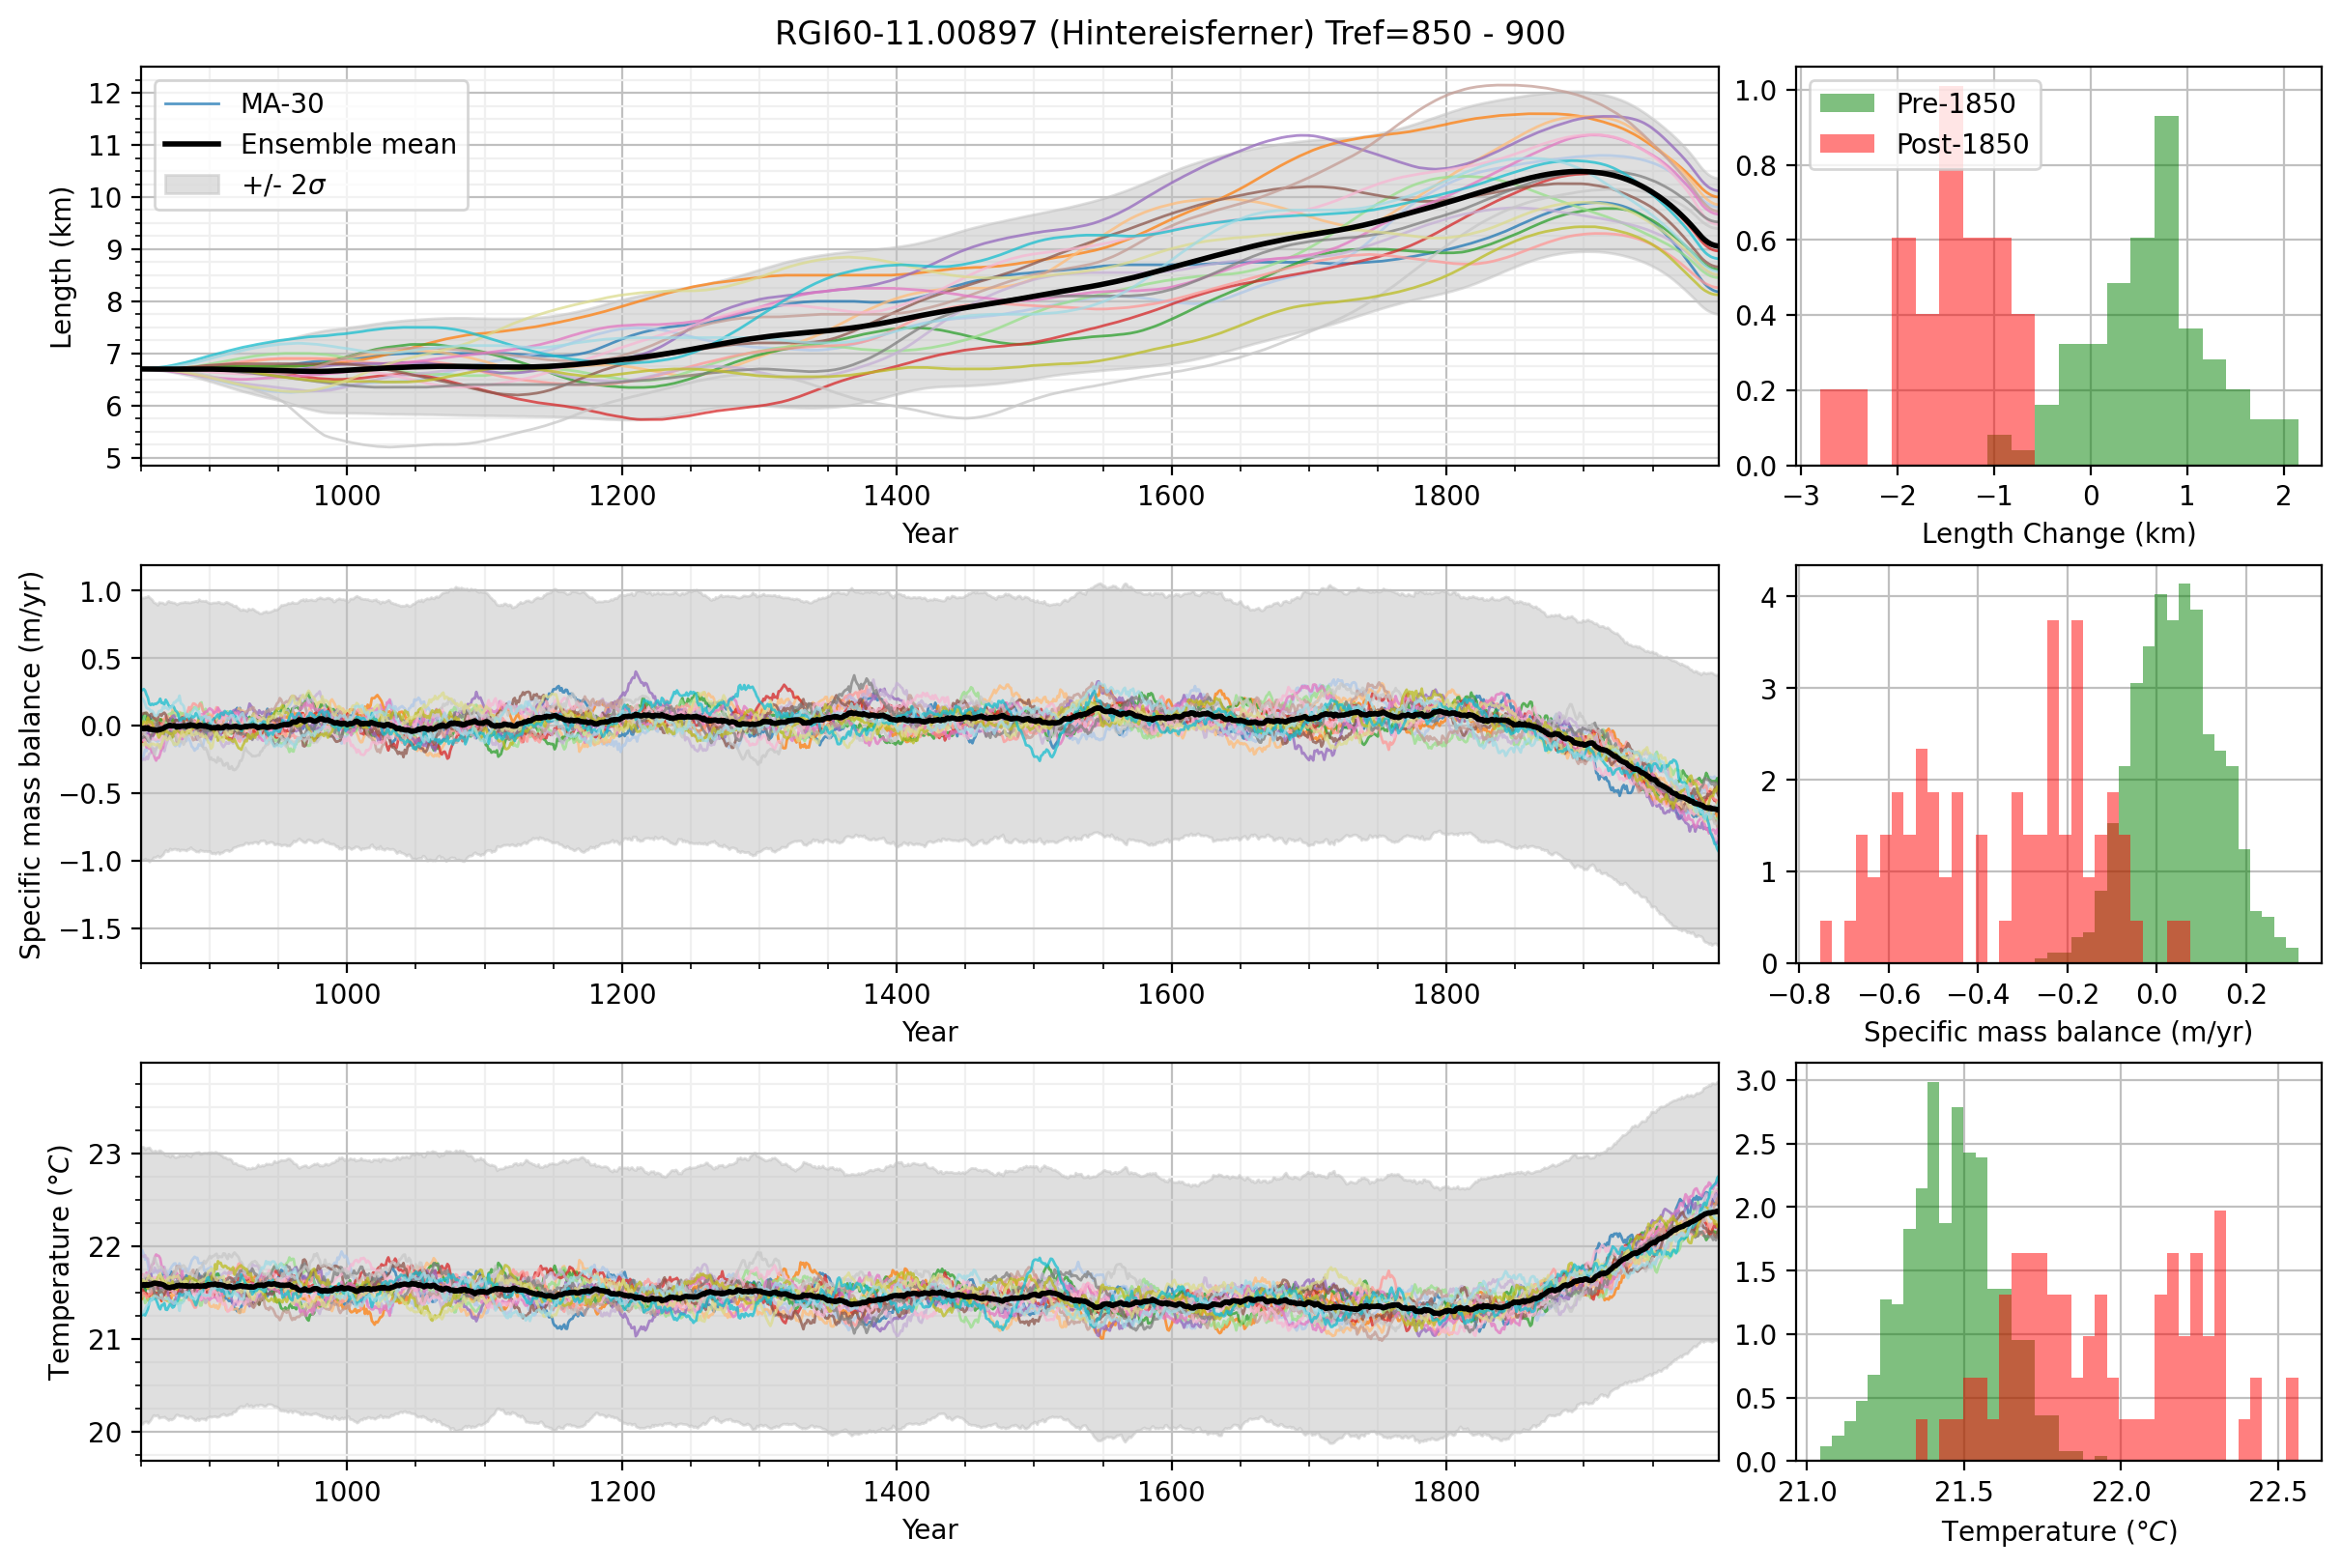

In [154]:

ensemble_dir = Path(r"C:\sandbox\glacier-attribution\models\ensembles\synthetic")
# ensemble_files = [f for f in list(ensemble_dir.iterdir()) if re.search(rf'{rgiids[0]}.lmr.[0-9]+.pickle', str(f.name))]
ensemble_files = [f for f in list(ensemble_dir.iterdir()) if re.search(rf'{rgiid}.synthetic.[0-9]+.pickle', str(f.name))]

# ensemble_files = ensemble_dir.glob(f'*{rgiids[0]}*.lmr.[0-9].early_ref.pickle')
runs = []
for p in ensemble_files:
    with open(p, "rb") as f:
        d = dill.load(f)
        runs.append(d)
runs = [run.to_xarray() for run in runs]
ds = xr.concat(runs, dim="nrun")

# calc specific mass balance for convenience
ds["sp_mb"] = ds.gwb / ds.area

# %%
sm_window = 30


def smooth(d, window=sm_window, axis=0):
    return sci.ndimage.uniform_filter1d(d, window, mode="mirror", axis=axis)


dm = ds.mean(dim="nrun")

ds_pi = ds.sel(time=slice(None, 1850))
ds_i = ds.sel(time=slice(1850, None))
# cmap = plt.cm.plasma(np.linspace(0, 0.75, len(ds.nrun)))
# cmap = plt.cm.brg(np.linspace(0, 1, len(ds.nrun)))
cmap = plt.cm.tab20(np.linspace(0, 1, len(ds.nrun)))
fig = plt.figure(figsize=(12, 8), dpi=200, layout="constrained")
gs = gridspec.GridSpec(3, 4, figure=fig, height_ratios=(1, 1, 1))
ax = np.empty((3, 2), dtype="object")
ax[0, 0] = fig.add_subplot(gs[0, 0:3])
ax[1, 0] = fig.add_subplot(gs[1, 0:3])
ax[2, 0] = fig.add_subplot(gs[2, 0:3])
ax[0, 1] = fig.add_subplot(gs[0, 3])
ax[1, 1] = fig.add_subplot(gs[1, 3])
ax[2, 1] = fig.add_subplot(gs[2, 3])
for nrun, d in ds.groupby("nrun"):
    if nrun == 0:
        label = f"MA-{sm_window}"
    else:
        label = None
    ax[0, 0].plot(
        d.time,
        smooth(d.edge / 1000),
        color=cmap[nrun],
        lw=1,
        alpha=0.75,
        label=label,
    )
    ax[1, 0].plot(
        d.time,
        smooth(d.gwb / d.area),
        color=cmap[nrun],
        lw=1,
        alpha=0.75,
        label=label,
    )
    ax[2, 0].plot(d.time, smooth(d.T), color=cmap[nrun], lw=1, alpha=0.75, label=label)


ax[0, 0].plot(
    dm.time,
    smooth(dm.edge / 1000),
    color="black",
    lw=2,
    label="Ensemble mean",
)
ax[0, 0].fill_between(
    dm.time,
    smooth(dm.edge / 1000 + 2 * (ds.edge / 1000).std(dim="nrun")),
    smooth(dm.edge / 1000 - 2 * (ds.edge / 1000).std(dim="nrun")),
    color="#c0c0c0",
    alpha=0.5,
    label="+/- 2$\sigma$",
)
ax[0, 0].set_ylabel("Length (km)")
dl_pi = (
    ds_pi.edge.sel(time=slice(1200, None, 150)).to_numpy().ravel() / 1000
    - ds_pi.edge.sel(time=slice(1050, 1700, 150)).to_numpy().ravel() / 1000
)
dl_i = ds_i.edge.isel(time=-1).to_numpy().ravel() / 1000 - ds_pi.edge.isel(time=-1).to_numpy().ravel() / 1000
bins = np.histogram(np.hstack((dl_pi, dl_i)), bins=20)[1]  # get the bin edges
ax[0, 1].hist(dl_pi, bins=bins, density=True, color="green", label="Pre-1850", alpha=0.5)
ax[0, 1].hist(dl_i, bins=bins, density=True, color="red", label="Post-1850", alpha=0.5)
ax[0, 1].set_xlabel("Length Change (km)")


ax[1, 0].plot(
    dm.time,
    smooth(dm.gwb / dm.area),
    color="black",
    lw=2,
    label="Ensemble mean",
)
ax[1, 0].fill_between(
    dm.time,
    smooth(dm.gwb / dm.area + 2 * (ds.gwb / ds.area).std(dim="nrun")),
    smooth(dm.gwb / dm.area - 2 * (ds.gwb / ds.area).std(dim="nrun")),
    color="#c0c0c0",
    alpha=0.5,
    label="+/- 2$\sigma$",
)
ax[1, 0].set_ylabel("Specific mass balance (m/yr)")
sp_mb_pi = ds_pi.sp_mb.coarsen(time=30, side="right", boundary="trim").mean().to_numpy().ravel()
sp_mb_i = ds_i.sp_mb.coarsen(time=30, side="right", boundary="trim").mean().to_numpy().ravel()
bins = np.histogram(np.hstack((sp_mb_pi, sp_mb_i)), bins=40)[1]  # get the bin edges
ax[1, 1].hist(
    sp_mb_pi,
    bins=bins,
    density=True,
    color="green",
    label="Pre-1850",
    alpha=0.5,
)
ax[1, 1].hist(
    sp_mb_i,
    bins=bins,
    density=True,
    color="red",
    label="Post-1850",
    alpha=0.5,
)
ax[1, 1].set_xlabel("Specific mass balance (m/yr)")

ax[2, 0].plot(dm.time, smooth(dm.T), c="black", lw=2, label="Ensemble mean")
ax[2, 0].fill_between(
    dm.time,
    smooth(dm.T + 2 * (ds.T).std(dim="nrun")),
    smooth(dm.T - 2 * (ds.T).std(dim="nrun")),
    color="#c0c0c0",
    alpha=0.5,
    label="+/- 2$\sigma$",
)

ax[2, 0].set_ylabel("Temperature ($\degree C$)")
T_pi = ds_pi.T.coarsen(time=30, side="right", boundary="trim").mean().to_numpy().ravel()
T_i = ds_i.T.coarsen(time=30, side="right", boundary="trim").mean().to_numpy().ravel()
bins = np.histogram(np.hstack((T_pi, T_i)), bins=40)[1]  # get the bin edges
ax[2, 1].hist(
    T_pi,
    bins=bins,
    density=True,
    color="green",
    label="Pre-1850",
    alpha=0.5,
)
ax[2, 1].hist(
    T_i,
    bins=bins,
    density=True,
    color="red",
    label="Post-1850",
    alpha=0.5,
)
ax[2, 1].set_xlabel("Temperature ($\degree C$)")
for j in np.arange(0, ax.shape[-1], 1):
    for i in np.arange(0, ax.shape[0], 1):
        if j == 0:
            ax[i, j].set_xlim(dm.time[j], dm.time[-1])
            ax[i, j].set_xlabel("Year")
            ax[i, j].xaxis.set_major_locator(MultipleLocator(200))
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(50))
        if i == 0:
            ax[i, j].legend(loc="upper left")
        ax[i, j].grid(which="major", axis="both", color="#c0c0c0")
        ax[i, j].grid(which="minor", axis="both", color="#f0f0f0")
        ax[i, j].set_axisbelow(True)
ax[0, 0].yaxis.set_major_locator(MultipleLocator(1))
ax[0, 0].yaxis.set_minor_locator(MultipleLocator(0.25))
ax[2, 0].yaxis.set_major_locator(MultipleLocator(1))
ax[2, 0].yaxis.set_minor_locator(MultipleLocator(0.25))
fig.suptitle(f"{rgiid} ({glacier}) Tref={ds.ref_period[0]} - {ds.ref_period[1]}")